<a href="https://colab.research.google.com/github/svperbeast/ai_lab/blob/main/imbalance_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#### Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [19]:
bank = pd.read_csv('Personal Loan.csv')
input_idx = [1,2,3,5,6,7,8,10,11,12,13]
target_idx = 9

X = np.array(bank.iloc[:, input_idx])
y = np.array(bank.iloc[:, target_idx])

X = X[y < 2,:]
y = y[y < 2]

sss = StratifiedShuffleSplit(n_splits=1,train_size=0.7)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [20]:
wgt = np.repeat(1/X_train.shape[0], X_train.shape[0])

model = DecisionTreeClassifier(max_depth=30, min_samples_split=20)
model.fit(X_train, y_train, sample_weight=wgt)

pred_y = model.predict(X_test)

x = confusion_matrix(y_true=y_test,y_pred=pred_y)
print("confusion matrix = \n", x)

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=pred_y).ravel()
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
auc = (1+tpr-fpr)/2

print("TPR: {:.3f}, FPR: {:.3f}, AUC: {:.3f}".format(tpr,fpr,auc))

confusion matrix = 
 [[672   1]
 [  8  69]]
TPR: 0.896, FPR: 0.001, AUC: 0.947


In [21]:
cit = np.array([])
ait = np.array([])
x_bst = np.array([])

wgt = np.repeat(1/X_train.shape[0], X_train.shape[0])
wgt[y_train==1] = 1/(2*np.sum(y_train==1))
wgt[y_train==0] = 1/(2*np.sum(y_train==0))

iter = 20

for i in range(0,iter):
    model = DecisionTreeClassifier(max_depth=2, min_samples_split=20)
    model.fit(X_train, y_train, sample_weight=wgt)

    ci = model.predict(X_train)
    cit = np.append(cit, ci).reshape(i+1,-1)

    tn, fp, fn, tp = confusion_matrix(y_train,ci).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)
    auc = (1+tpr-fpr)/2
    x_bst = np.append(x_bst, auc)


    ai = 0.5 * np.log(wgt[ci == y_train].sum()/wgt[ci != y_train].sum())
    ait = np.append(ait, ai)

    loss = np.exp(-ai*np.sign((ci == y_train)-0.5))
    wls = wgt * loss
    zi_pos = np.sum(wls[y_train==1])
    zi_neg = np.sum(wls[y_train==0])

    wls[y_train==1] *= 1/zi_pos
    wls[y_train==0] *= 1/zi_neg

    wgt = wls

    print("iteration {:3d},TPR: {:.3f}, FPR: {:.3f}, AUC: {:.3f}".format(i,tpr,fpr,auc))

iteration   0,TPR: 1.000, FPR: 0.240, AUC: 0.880
iteration   1,TPR: 0.827, FPR: 0.154, AUC: 0.836
iteration   2,TPR: 0.777, FPR: 0.081, AUC: 0.848
iteration   3,TPR: 0.732, FPR: 0.129, AUC: 0.802
iteration   4,TPR: 0.330, FPR: 0.014, AUC: 0.658
iteration   5,TPR: 0.615, FPR: 0.431, AUC: 0.592
iteration   6,TPR: 0.503, FPR: 0.018, AUC: 0.742
iteration   7,TPR: 0.330, FPR: 0.017, AUC: 0.657
iteration   8,TPR: 0.017, FPR: 0.058, AUC: 0.479
iteration   9,TPR: 0.335, FPR: 0.028, AUC: 0.654
iteration  10,TPR: 0.777, FPR: 0.185, AUC: 0.796
iteration  11,TPR: 0.916, FPR: 0.194, AUC: 0.861
iteration  12,TPR: 0.302, FPR: 0.177, AUC: 0.562
iteration  13,TPR: 0.855, FPR: 0.458, AUC: 0.698
iteration  14,TPR: 0.581, FPR: 0.595, AUC: 0.493
iteration  15,TPR: 0.330, FPR: 0.035, AUC: 0.647
iteration  16,TPR: 0.017, FPR: 0.058, AUC: 0.479
iteration  17,TPR: 0.017, FPR: 0.058, AUC: 0.479
iteration  18,TPR: 0.883, FPR: 0.476, AUC: 0.703
iteration  19,TPR: 0.335, FPR: 0.028, AUC: 0.654


In [22]:
cit = np.sign(1*(cit == 1)-0.5)

In [23]:
pred = np.array([])
for i in range(0,iter):
    x = 0
    for j in range(0,i+1):
        x = x + ait[j]*cit[j,:]
    # print(x)
    pred = np.append(pred, x)

pred = np.sign(pred.reshape(iter,-1))

print(pred)

y_bst = np.array([])
y_train_tmp = np.sign((y_train==1)-0.5)
for i in range(0,iter):
    tn, fp, fn, tp = confusion_matrix(y_train_tmp,pred[i,:]).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)
    auc = (1+tpr-fpr)/2
    y_bst = np.append(y_bst, auc)


    print("iteration {:3d},TPR: {:.3f}, FPR: {:.3f}, AUC: {:.3f}".format(i,tpr,fpr,auc))

[[ 1.  1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [-1.  1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]]
iteration   0,TPR: 1.000, FPR: 0.240, AUC: 0.880
iteration   1,TPR: 1.000, FPR: 0.240, AUC: 0.880
iteration   2,TPR: 0.955, FPR: 0.049, AUC: 0.953
iteration   3,TPR: 0.955, FPR: 0.049, AUC: 0.953
iteration   4,TPR: 0.961, FPR: 0.055, AUC: 0.953
iteration   5,TPR: 0.961, FPR: 0.051, AUC: 0.955
iteration   6,TPR: 0.950, FPR: 0.036, AUC: 0.957
iteration   7,TPR: 0.950, FPR: 0.036, AUC: 0.957
iteration   8,TPR: 0.950, FPR: 0.035, AUC: 0.957
iteration   9,TPR: 0.944, FPR: 0.033, AUC: 0.956
iteration  10,TPR: 0.950, FPR: 0.035, AUC: 0.957
iteration  11,TPR: 0.944, FPR: 0.036, AUC: 0.954
iteration  12,TPR: 0.950, FPR: 0.034, AUC: 0.958
iteration  13,TPR: 0.950, FPR: 0.036, AUC: 0.957
iteration  14,TPR: 0.950, FPR: 0.035, AUC: 0.957
iteration  15,TPR: 0.950, FPR: 0.030, AUC: 0.960
iteration  16,TPR: 0.950

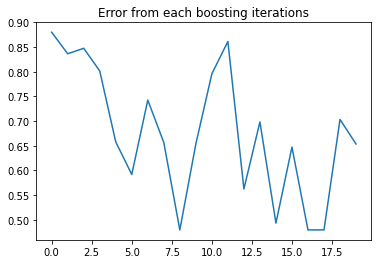

In [24]:
plt.plot(range(0,iter), x_bst)
plt.title('Error from each boosting iterations')
plt.show()

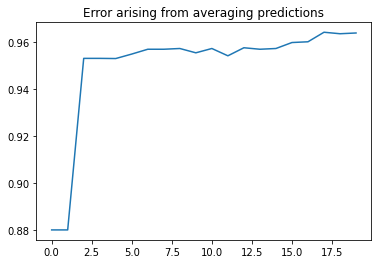

In [25]:
plt.plot(range(0,iter), y_bst)
plt.title("Error arising from averaging predictions")
plt.show()